## Configuration for Colab

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt-get install -y xvfb python-opengl > /dev/null 2>&1
    !pip install gym pyvirtualdisplay > /dev/null 2>&1
    !pip install JSAnimation==0.1
    !pip install pyglet==1.3.2
    
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

# 04. Proximal Policy Optimization (PPO)

## Import modules

In [2]:
import random
from collections import deque
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Normal

## Network

In [ ]:
def init_layer_uniform(layer: nn.Linear, init_w: float = 3e-3) -> nn.Linear:
    """Init uniform parameters on the single layer."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)

    return layer


class Actor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        log_std_min: float = -20,
        log_std_max: float = 2,
    ):
        """Initialization."""
        super(Actor, self).__init__()
        
        # set the log std range
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        # set the hidden layers
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        
        # set log_std layer
        self.log_std_layer = nn.Linear(128, out_dim)
        self.log_std_layer = init_layer_uniform(self.log_std_layer)

        # set mean layer
        self.mu_layer = nn.Linear(128, out_dim)
        self.mu_layer = init_layer_uniform(self.mu_layer)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        
        # get mean
        mu = torch.tanh(self.mu_layer(x))
        
        # get std
        log_std = torch.tanh(self.log_std_layer(x))
        log_std = self.log_std_min + 0.5 * (
            self.log_std_max - self.log_std_min
        ) * (log_std + 1)
        std = torch.exp(log_std)
        
        # sample actions
        dist = Normal(mu, std)
        action = dist.sample()
        
        return action, dist
    
class Critic(nn.Module):
    def __init__(self, in_dim: int):
        """Initialization."""
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        self.out = init_layer_uniform(self.out)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        value = self.out(x)
        
        return value

## GAE

In [4]:
def compute_gae(
    next_value: list,
    rewards: list,
    masks: list,
    values: list,
    gamma: float = 0.99,
    tau: float = 0.95,
) -> List:
    """Compute gae."""
    values = values + [next_value]
    gae = 0
    returns: deque = deque()

    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.appendleft(gae + values[step])

    return list(returns)

## PPO Agent
Here is a summary of Agent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_plot              | plot the training progresses.                      |

In [5]:
def ppo_iter(
    epoch: int,
    mini_batch_size: int,
    states: torch.Tensor,
    actions: torch.Tensor,
    values: torch.Tensor,
    log_probs: torch.Tensor,
    returns: torch.Tensor,
    advantages: torch.Tensor,
):
    """Yield mini-batches."""
    batch_size = states.size(0)
    for _ in range(epoch):
        for _ in range(batch_size // mini_batch_size):
            rand_ids = np.random.choice(batch_size, mini_batch_size)
            yield states[rand_ids, :], actions[rand_ids], values[
                rand_ids
            ], log_probs[rand_ids], returns[rand_ids], advantages[rand_ids]

class PPOAgent:
    """PPO Agent.
    Attributes:
        env (gym.Env or SubprocVecEnv): Gym env with multiprocessing for training
        gamma (float): discount factor
        entropy_weight (float): rate of weighting entropy into the loss function
        device (torch.device): cpu / gpu
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """
    def __init__(
        self,
        env: gym.Env,
        batch_size = 5,
        gamma: float = 0.99,
        tau: float = 0.95,
        epsilon: float = 0.2,
        epoch: int = 32,
        rollout_len: int = 128,
        entropy_weight: float = 1e-3
    ):
        """Initialization."""
        self.env = env
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon
        self.epoch = epoch
        self.rollout_len = rollout_len
        self.entropy_weight = entropy_weight
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        
        # networks
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.critic = Critic(obs_dim).to(self.device)
        
        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        # memory for training
        self.states: list = []
        self.actions: list = []
        self.rewards: list = []
        self.values: list = []
        self.masks: list = []
        self.log_probs: list = []
        
        # total steps count
        self.total_step = 1

        # mode: train / test
        self.is_test = False
        
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        state = torch.FloatTensor(state).to(self.device)
        action, dist = self.actor(state)
        selected_action = dist.mean if self.is_test else action

        if not self.is_test:
            value = self.critic(state)
            self.states.append(state)
            self.actions.append(selected_action)
            self.values.append(value)
            self.log_probs.append(dist.log_prob(selected_action))
        
        return selected_action.cpu().detach().numpy()
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)
        
        if not self.is_test:
            self.rewards.append(torch.FloatTensor([reward]).to(self.device))
            self.masks.append(torch.FloatTensor([1 - done]).to(self.device))
    
        return next_state, reward, done
        
    def update_model(
        self, next_state: np.ndarray
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines
        
        next_state = torch.FloatTensor(next_state).to(device)
        next_value = self.critic(next_state)
        
        returns = compute_gae(
            next_value, self.rewards, self.masks, self.values, self.gamma, self.tau
        )
        
        states = torch.cat(self.states).view(-1, 3)
        actions = torch.cat(self.actions)
        returns = torch.cat(returns).detach()
        values = torch.cat(self.values).detach()
        log_probs = torch.cat(self.log_probs).detach()
        advantages = returns - values
        
        actor_losses, critic_losses, total_losses = [], [], []
        
        """Yield mini-batches."""
        batch_size = states.size(0)
        for _ in range(epoch):
            for _ in range(batch_size // mini_batch_size):
                rand_ids = np.random.choice(batch_size, mini_batch_size)
                yield states[rand_ids, :], actions[rand_ids], values[
                    rand_ids
                ], log_probs[rand_ids], returns[rand_ids], advantages[rand_ids]
        
        for state, action, old_value, old_log_prob, return_, adv in ppo_iter(
            self.epoch,
            self.batch_size,
            states,
            actions,
            values,
            log_probs,
            returns,
            advantages,
        ):
            # calculate ratios
            _, dist = self.actor(state)
            log_prob = dist.log_prob(action)
            ratio = (log_prob - old_log_prob).exp()
            
            # actor_loss
            surr_loss = ratio * adv
            clipped_surr_loss = (
                torch.clamp(ratio, 1.0 - self.epsilon, 1.0 + self.epsilon) * adv
            )
            actor_loss = -torch.min(surr_loss, clipped_surr_loss).mean()

            # critic_loss
            value = self.critic(state)
            critic_loss = (return_ - value).pow(2).mean()
            
            # entropy
            entropy = dist.entropy().mean()

            # total_loss
            total_loss = actor_loss + critic_loss - entropy * self.entropy_weight
            
            # train critic
            self.critic_optimizer.zero_grad()
            total_loss.backward(retain_graph=True)
            self.critic_optimizer.step()

            # train actor
            self.actor_optimizer.zero_grad()
            total_loss.backward()
            self.actor_optimizer.step()

            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())
            total_losses.append(total_loss.item())
        
        self.states, self.actions, self.rewards = [], [], []
        self.values, self.masks, self.log_probs = [], [], []

        actor_loss = sum(actor_losses) / len(actor_losses)
        critic_loss = sum(critic_losses) / len(critic_losses)
        total_loss = sum(total_losses) / len(total_losses)

        return actor_loss, critic_loss, total_loss
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        actor_losses, critic_losses, total_losses = [], [], []
        scores = []
        score = 0
        
        
        while self.total_step <= num_frames + 1:
            for _ in range(self.rollout_len):
                self.total_step += 1
                action = self.select_action(state)
                next_state, reward, done = self.step(action)
                
                state = next_state
                score += reward
                
                # if episode ends
                if done:
                    state = env.reset()
                    scores.append(score)
                    score = 0
                
                # potting
                if self.total_step % plotting_interval == 0:
                    self._plot(
                        self.total_step, scores, actor_losses, critic_losses, total_losses
                    )
            
            actor_loss, critic_loss, total_loss = self.update_model(next_state)
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)
            total_losses.append(total_loss)
                    
        # termination
        self.env.close()
        
    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float],
        total_losses: List[float],
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (141, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (142, "actor_loss", actor_losses),
            (143, "critic_loss", critic_losses),
            (144, "total_losses", total_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

## Environment
**ActionNormalizer** is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [6]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

You can see [the code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) and [configurations](https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81) of Pendulum-v0 from OpenAI's repository.

In [7]:
# environment
env_id = "Pendulum-v0"
env = gym.make(env_id)
env = ActionNormalizer(env)

## Set random seed

In [8]:
def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

seed = 777
np.random.seed(seed)
seed_torch(seed)
env.seed(seed)

[777]

## Initialize

In [9]:
# parameters
num_frames = 1000000

agent = PPOAgent(env)

cuda


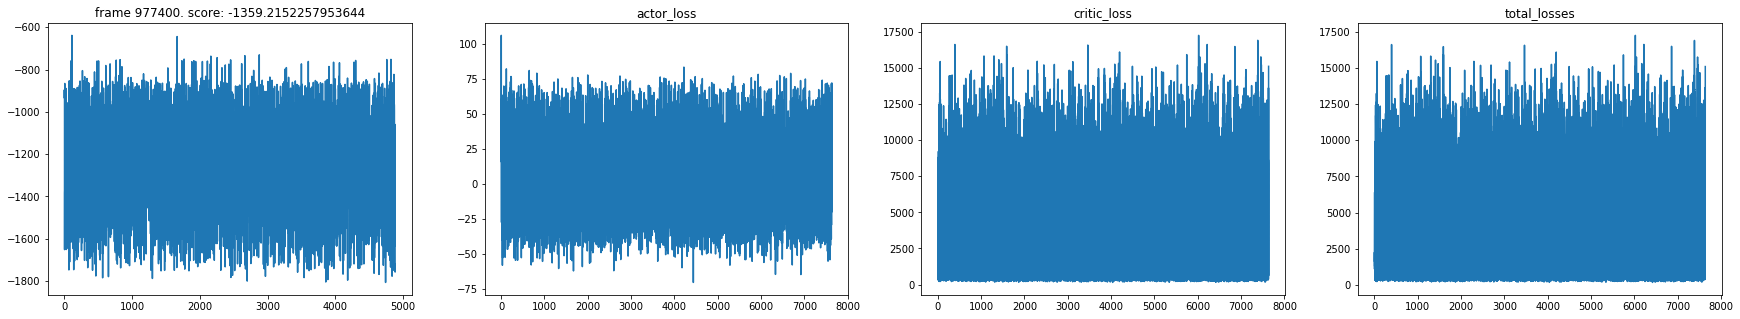

In [ ]:
agent.train(num_frames)

In [ ]:
frames = agent.test()

In [ ]:
# Imports specifically so we can render outputs in Colab.
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display


def display_frames_as_gif(frames):
    """Displays a list of frames as a gif, with controls."""
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(
        plt.gcf(), animate, frames = len(frames), interval=50
    )
    display(display_animation(anim, default_mode='loop'))
    
        
# display 
display_frames_as_gif(frames)